In [1]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery

%matplotlib inline
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

## ******************************************************************************************************************************
## BIG QUERY CREDENTIALS
## ******************************************************************************************************************************

bq_client = bigquery.Client.from_service_account_json('my-service-account-key.json')
bq_project = 'my-bq-project'
bq_table = 'cartobq.sdsc24_ny_workshops.CHI_boundary_enriched_w_lags'
selected_h3 = '872664c8cffffff'

2024-09-25 12:12:22.997453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 12:12:24.078247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 12:12:24.564108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 12:12:27.467139: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plotting setup

In [2]:
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

## Read the data

In [3]:
q = f'''
WITH T AS(
    SELECT *
    FROM `{bq_table}`
    WHERE total_pop_sum > 0
    ORDER BY h3, week
)
SELECT *
FROM T
'''
df = bq_client.query(q).to_dataframe()

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [4]:
df.head()

,week,h3,counts,year,month,total_pop_sum,median_age_avg,median_rent_avg,black_pop_sum,hispanic_pop_sum,...,principal_component_1,principal_component_2,counts_ratio,counts_ratio_kring2,counts_ratio_lag_1,counts_ratio_lag_2,counts_ratio_lag_3,seasonal_sin,seasonal_cos,holiday_name
0,2001-01-01,872664190ffffff,0,2001,1,1673.697011,33.056793,433.500241,270.746072,939.837977,...,-3.100284,2.01476,0.0,1.222737,NaN,NaN,NaN,0.5,0.866025,NewYear
1,2001-01-08,872664190ffffff,0,2001,1,1673.697011,33.056793,433.500241,270.746072,939.837977,...,-3.100284,2.01476,0.0,0.738535,0.0,NaN,NaN,0.5,0.866025,None
2,2001-01-15,872664190ffffff,0,2001,1,1673.697011,33.056793,433.500241,270.746072,939.837977,...,-3.100284,2.01476,0.0,1.965475,0.0,0.0,NaN,0.5,0.866025,US_MLKDay
3,2001-01-22,872664190ffffff,0,2001,1,1673.697011,33.056793,433.500241,270.746072,939.837977,...,-3.100284,2.01476,0.0,1.054072,0.0,0.0,0.0,0.5,0.866025,None
4,2001-01-29,872664190ffffff,0,2001,1,1673.697011,33.056793,433.500241,270.746072,939.837977,...,-3.100284,2.01476,0.0,1.291739,0.0,0.0,0.0,0.5,0.866025,US_Superbowl


In [5]:
df.columns

Index(['week', 'h3', 'counts', 'year', 'month', 'total_pop_sum',
       'median_age_avg', 'median_rent_avg', 'black_pop_sum',
       'hispanic_pop_sum', 'owner_occupied_housing_units_median_value_sum',
       'vacant_housing_units_sum', 'housing_units_sum',
       'families_with_young_children_sum', 'urbanity_any',
       'urbanity_any_ordinal', 'principal_component_1',
       'principal_component_2', 'counts_ratio', 'counts_ratio_kring2',
       'counts_ratio_lag_1', 'counts_ratio_lag_2', 'counts_ratio_lag_3',
       'seasonal_sin', 'seasonal_cos', 'holiday_name'],
      dtype='object')

In [6]:
data = np.array((df[df.h3 == selected_h3]['counts_ratio']), dtype=np.float32)
dates = np.array(df[df.h3 == selected_h3]['week'])

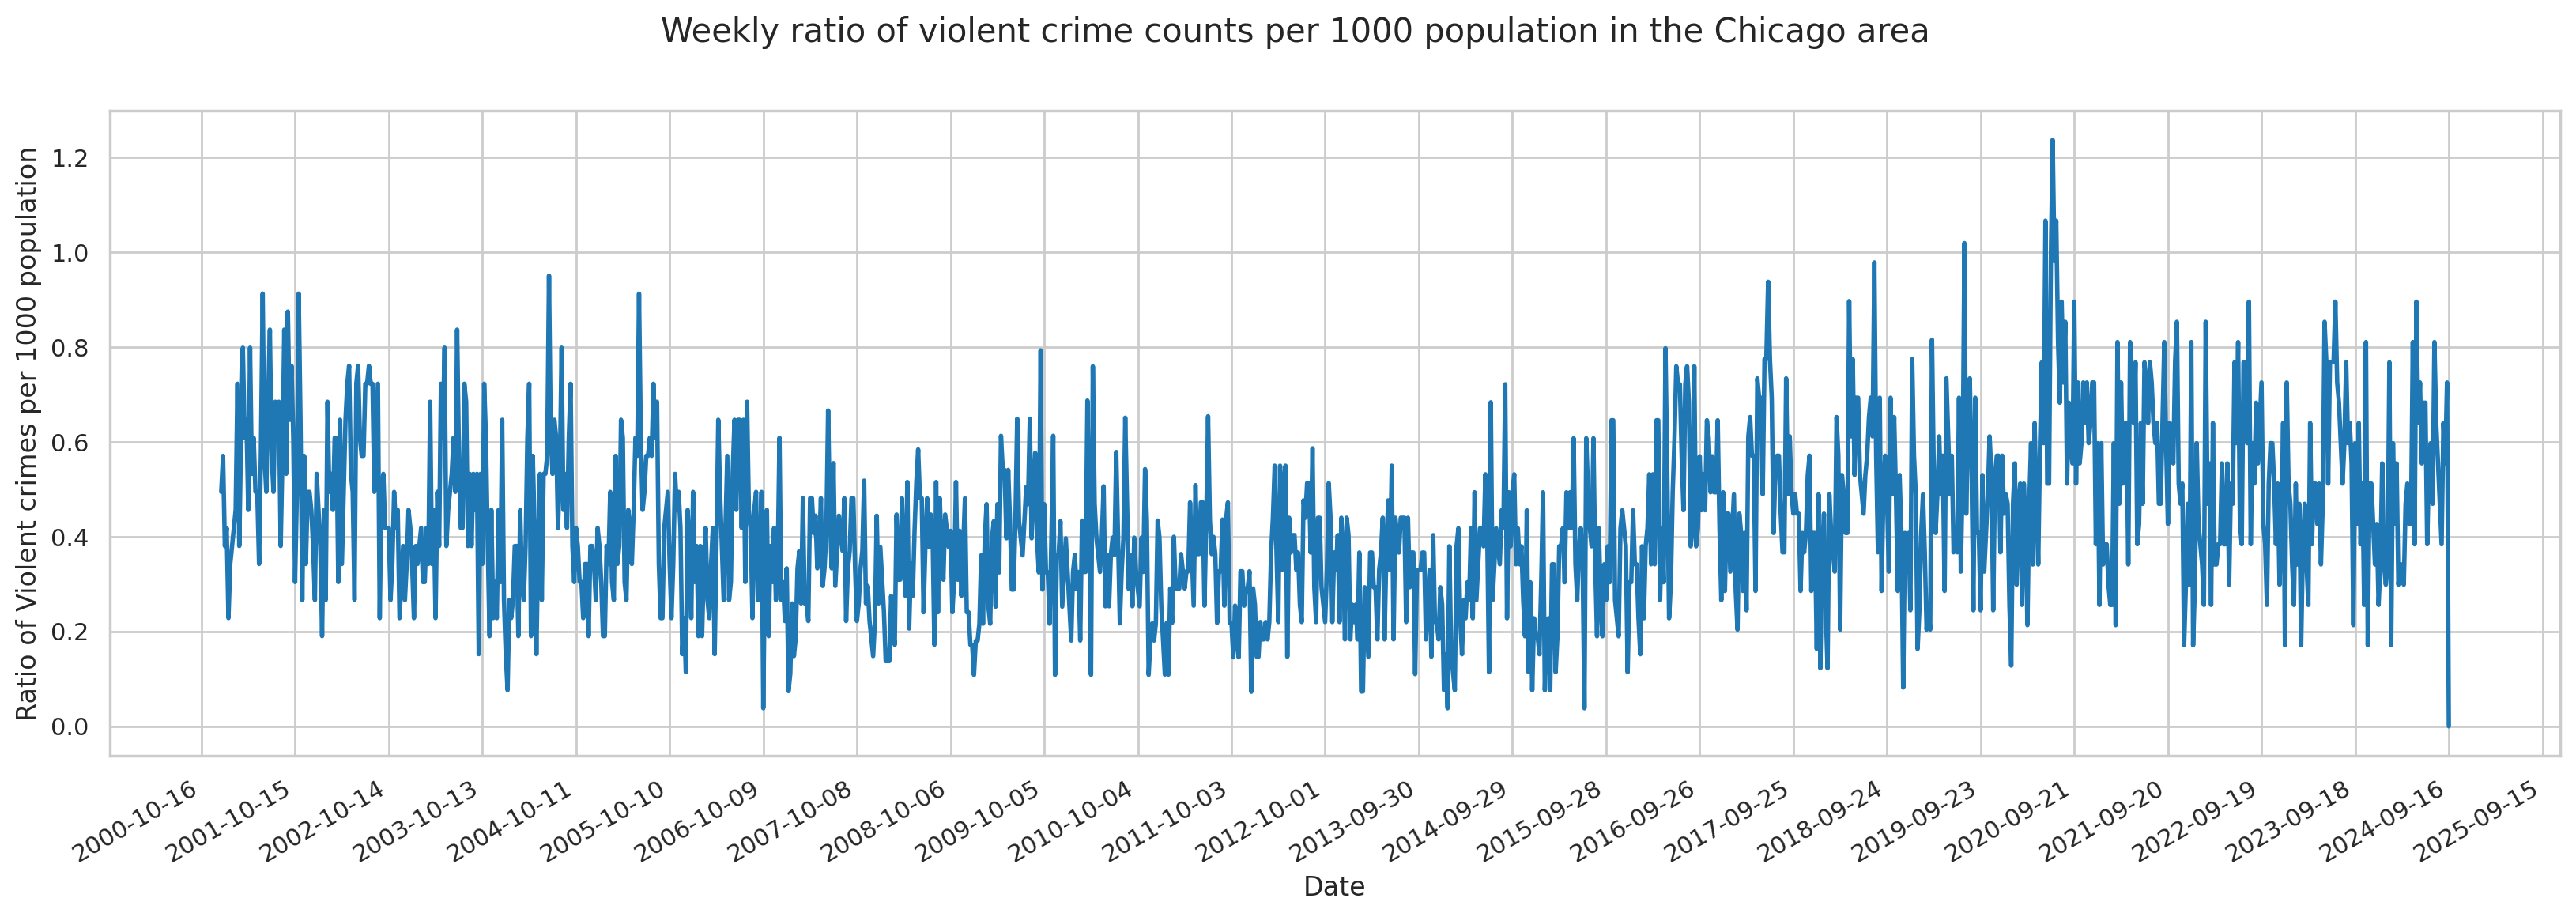

In [7]:
from matplotlib.dates import MO

loc = mdates.WeekdayLocator(byweekday=MO, interval=52)
fmt = mdates.AutoDateFormatter(loc)

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(dates, data, lw=2, label="training data")
ax.set_ylabel("Ratio of Violent crimes per 1000 population")
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(fmt)
fig.suptitle("Weekly ratio of violent crime counts per 1000 population in the Chicago area",
             fontsize=15)
ax.text(0.99, .02,
        "",
        transform=ax.transAxes,
        horizontalalignment="right",
        alpha=0.5)
fig.autofmt_xdate()

## Train model

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
import onnx
from sklearn.pipeline import Pipeline

In [9]:
def generate_initial_types(column_names_and_types):
    # Initialize an empty list to hold the generated types
    initial_types = []
    
    # Loop over each column and its specified type
    for column_name, col_type in column_names_and_types.items():
        # Append the appropriate TensorType based on the provided column type
        if col_type == 'float':
            initial_types.append((column_name, FloatTensorType([None, 1])))  # [None, 1] for each float column
        elif col_type == 'int':
            initial_types.append((column_name, Int64TensorType([None, 1])))  # [None, 1] for each int column
        elif col_type == 'string':
            initial_types.append((column_name, StringTensorType([None, 1])))  # [None, 1] for each string column
        else:
            raise ValueError(f"Unsupported column type: {col_type} for column: {column_name}")
    
    return initial_types

In [10]:
df.shape

(142422, 26)

## Set up features (lags + covariates) and response variable

In [11]:
model_filename = 'arima_plus_model_opset8_onehot'
group_col = 'h3'
feature_cols_names_and_types = {
    'h3': 'string',
    'counts_ratio_lag_1': 'float',
    'counts_ratio_lag_2': 'float',
    'counts_ratio_lag_3': 'float',
    'principal_component_1': 'float',
    'principal_component_2': 'float',
    'seasonal_sin': 'float',
    'seasonal_cos': 'float'
}

feature_cols = list(feature_cols_names_and_types.keys())
df = df.dropna(subset = feature_cols)  # Drop the NaN values created by shifting

## Train model and save it locally

In [12]:
X = df[feature_cols]
y = df['counts_ratio']

preprocessor = ColumnTransformer(
    transformers=[
        ('group', OneHotEncoder(), [group_col]),
        ('num', StandardScaler(), [x for x in feature_cols if x!=group_col])
    ],
    remainder='passthrough'
)

pipe = Pipeline([('preprocessor', preprocessor),
                ('clr', LinearRegression())])
pipe.fit(X, y)

# Disable zipmap as it is not supported in BigQuery ML.
options = {id(pipe): {'zipmap': False}}

# Define input features. scikit-learn does not store information about the
# training dataset. It is not always possible to retrieve the number of features
# or their types. That's why the function needs another argument called initial_types.
initial_types = generate_initial_types(feature_cols_names_and_types)

# Convert the model.
model_onnx = convert_sklearn(
   pipe, model_filename, initial_types=initial_types, target_opset=8
)

# And save.
with open(f'{model_filename}.onnx', 'wb') as f:
    f.write(model_onnx.SerializeToString())

In [13]:
# Convert the model.
model_onnx = convert_sklearn(
   pipe, model_filename, initial_types=initial_types, target_opset=8
)

# And save.
with open(f'{model_filename}.onnx', 'wb') as f:
    f.write(model_onnx.SerializeToString())

In [15]:
data_pred = pipe.predict(X[X.h3 == selected_h3])
dates_pred = np.array(df[df.h3 == df.h3.iloc[0]]['week'])

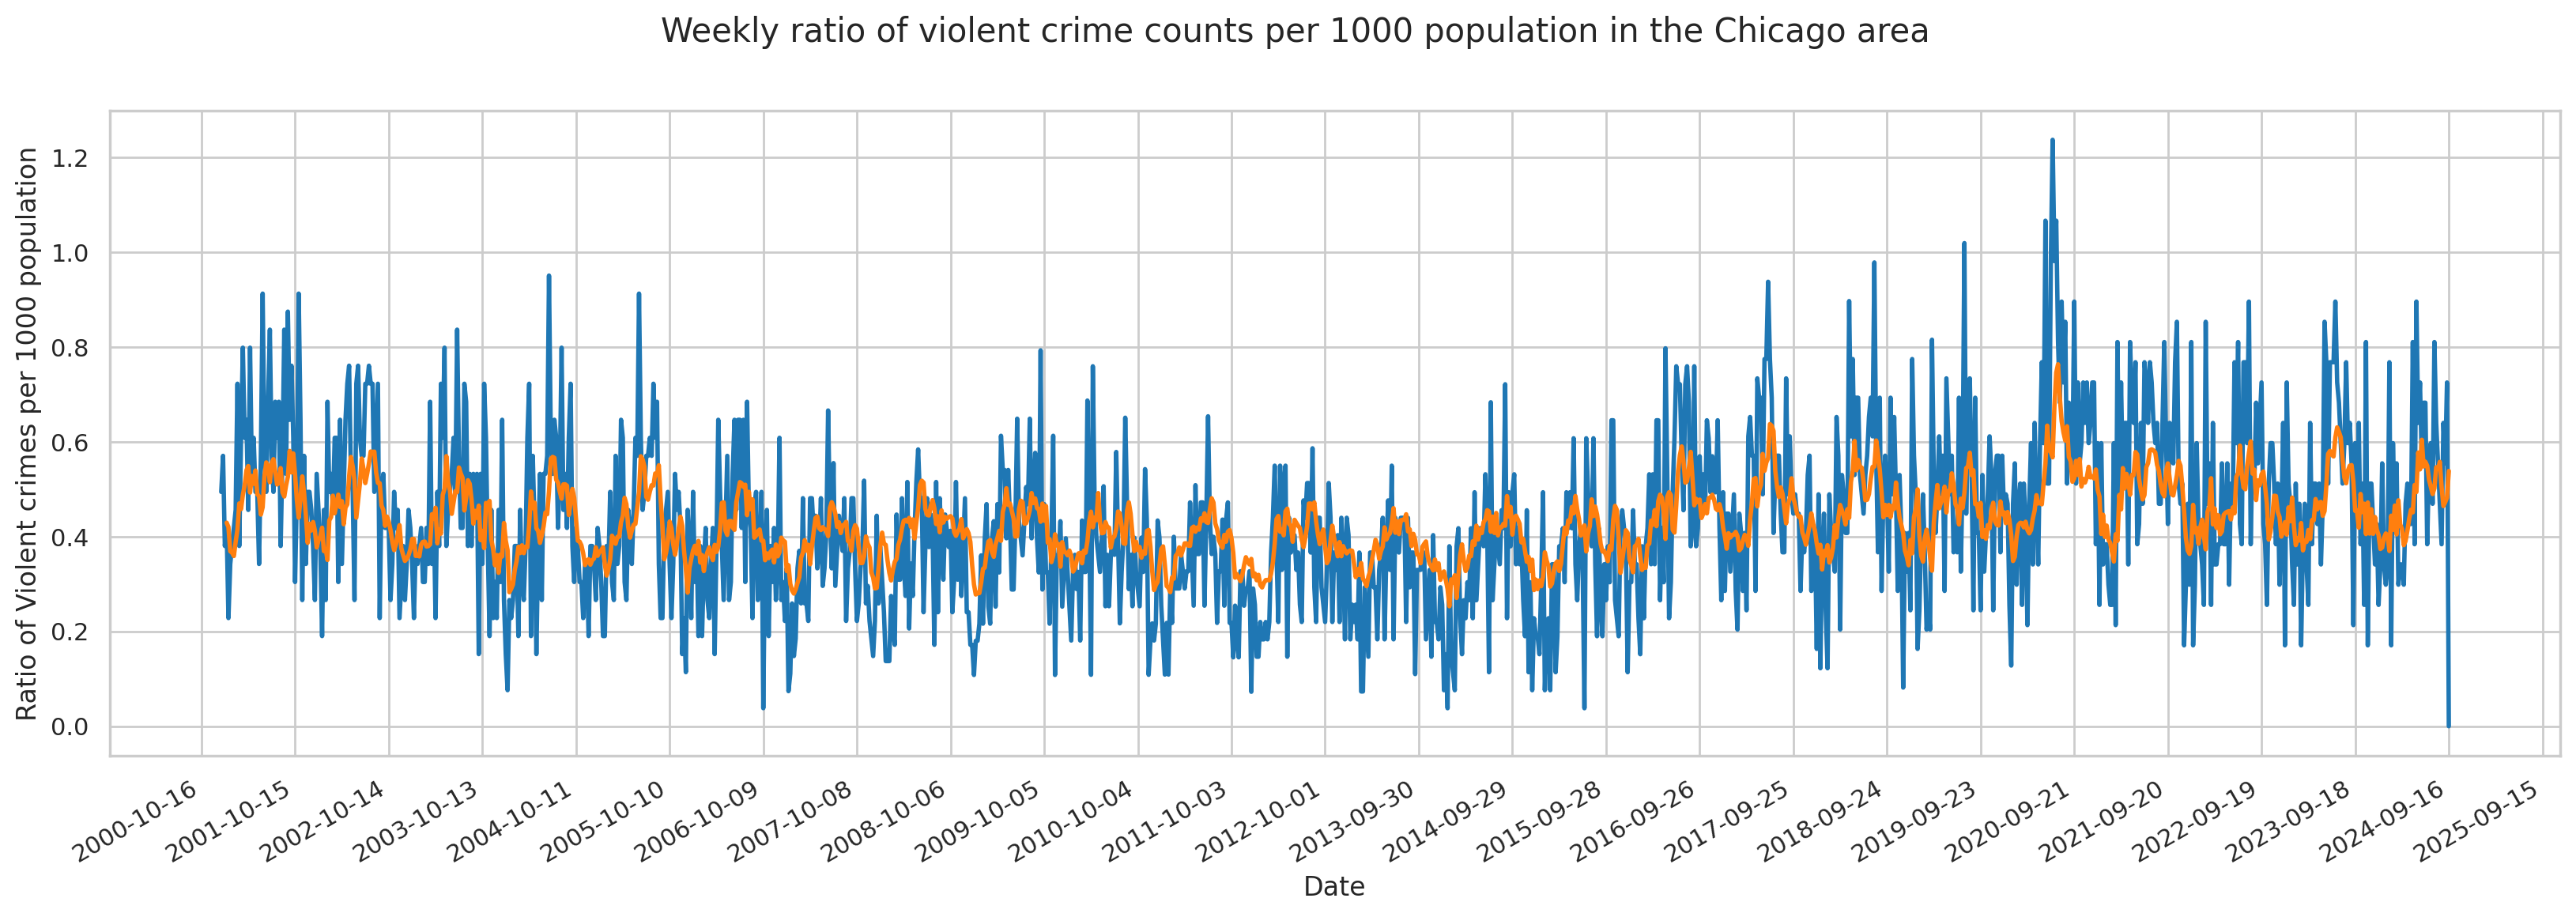

In [17]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 1, 1)
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]
ax.plot(dates, data, lw=2, color = c1, label="training data")
ax.plot(dates_pred, data_pred, lw=2, color = c2, label="predicted data")
ax.set_ylabel("Ratio of Violent crimes per 1000 population")
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(fmt)
fig.suptitle("Weekly ratio of violent crime counts per 1000 population in the Chicago area",
             fontsize=15)
ax.text(0.99, .02,
        "",
        transform=ax.transAxes,
        horizontalalignment="right",
        alpha=0.5)
fig.autofmt_xdate()

## Upload model to Google Cloud Storage

In [ ]:
from google.cloud import storage

def upload_to_gcs(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to Google Cloud Storage."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print(f"Model uploaded to: gs://{bucket_name}/{destination_blob_name}")

bucket_name = "giulia_analytics_toolbox_dev"
source_file_name = f"./{model_filename}.onnx"
destination_blob_name = f'onnx_models/{model_filename}.onnx'

# Upload the file to GCS
upload_to_gcs(bucket_name, source_file_name, destination_blob_name)